In [3]:
from sklearn.cluster import KMeans
import pandas as pd
import math
from scipy import fft, fftpack
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import timedelta
sns.set(style="darkgrid")
%config IPCompleter.greedy = True
%config Completer.use_jedi = False

In [9]:
data = pd.read_csv("../../data/merged_data.csv")
data['date_dt'] = pd.to_datetime(data['date'])

In [10]:
# Range of dates in the dataset
date_range = pd.date_range(start=data.date_dt.min().date(), end=data.date_dt.max().date())

In [4]:
# Defines the split for which data is considered reoccuring and which is not
non_reoccuring_number = 100
# minute_floor defines the interval by which the dataset will be grouped
minute_floor = 15

# Grouping data into minute intervals #

In [12]:
# Groups the data into minute_floor intervals
data['minutes'] = data['minutes'].apply(lambda x: int(math.floor(x / minute_floor) * minute_floor))
data['minutes'].value_counts()

0     16299873
30    16270324
15    16245423
45    16177995
Name: minutes, dtype: int64

In [13]:
floor_data = data.groupby(['hash','date','hours','minutes']).size()

In [14]:
del data

In [21]:
lesser_series = floor_data.groupby(["hash"]).sum() < 100

In [32]:
lesser_series[~lesser_series]

hash
0003b414e261be6505384bc2eae1b0d4    False
000f5b86453d04cec345efac3910630f    False
000faa3899786b1c9dedbf67fd7322d6    False
000fcac94f26d1ab0330218845db1a70    False
00109b7805dfca5a600d5339194af098    False
                                    ...  
ffd76de3b450242691dd3e012c685dd5    False
ffdb968980aaf93f347b15e4ce0dd37a    False
fff51929fb74274a7d7477e5519df718    False
fff67e5b94d92292e4c524c6bb28cb88    False
fffaf6aa9d07f10a36b56a59d501a747    False
Length: 14021, dtype: bool

In [37]:
reset_floor = floor_data.reset_index()

# Recurring and non-recurring series comparison

<AxesSubplot:xlabel='date,hours'>

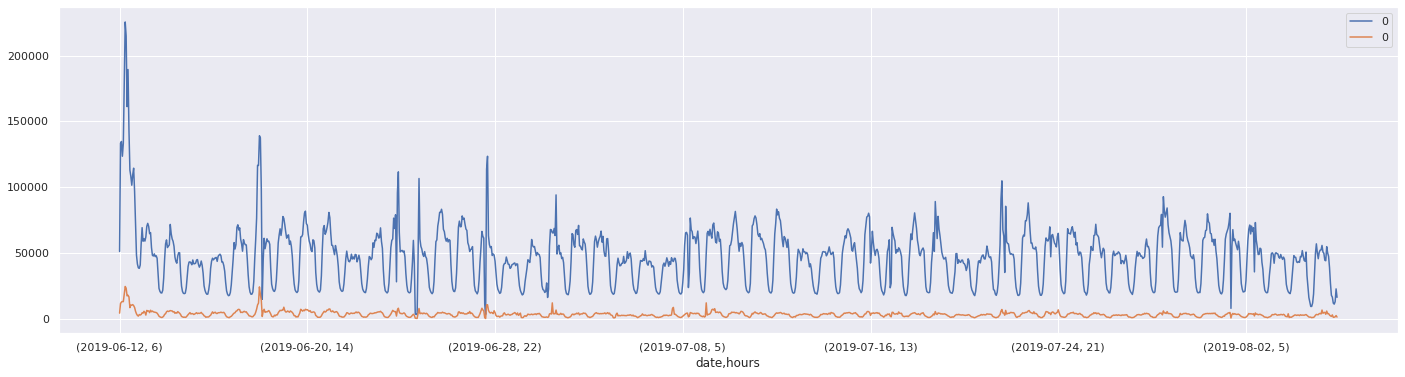

In [51]:
fig, ax = plt.subplots()
fig.set_size_inches(24,6)

reset_floor[reset_floor['hash'].isin(lesser_series[~lesser_series].index)].drop(columns=["minutes"]).groupby(["date", "hours"]).sum().plot(ax=ax)
reset_floor[reset_floor['hash'].isin(lesser_series[lesser_series].index)].drop(columns=["minutes"]).groupby(["date", "hours"]).sum().plot(ax=ax)

# Correcting and removing fluctuations in data caused by disturbing events during collection

Requests from 12.06.2019 (Lasting until morning the following day) will be removed as the amount of traffic collected from the logs accounts for 12.5%, while most days account for 6.25%. This day is removed to eliminate the difference in scale and remove its ability to alter the outcome. Since it is the first day removing it is easy, it will not create a hole in otherwise continuous data.

01.07.2019 and 06.08.2019 introduced a gap in the data collected. This has been confirmed as being caused by downtime for deployments on the tracked servers. 

The requests from 06.08.2019 will be removed as they are the last day in the dataset, so once again, the continuity of the data is preserved and the anomaly removed. 
Theoretically, the data from 06.08 could be preserved without hurting continuality, at least on an hourly and minute scale, but will still be visible on the daily scale. As there is no lack of data, it will be removed. 

As for the gap in requests on 01.07.2019, it will be filled with average values in order to resemble other unaffected days. This, while not ideal, will allow preservation of continuity and should not cause significant trouble or cast doubt on the outcomes.

Here we, however, need to be careful. We cant expect that the deployment took an entire day and so it is necessary to identify the time period of the downtime.

These anomalies can be observed in the 1-data_analysis notebook.

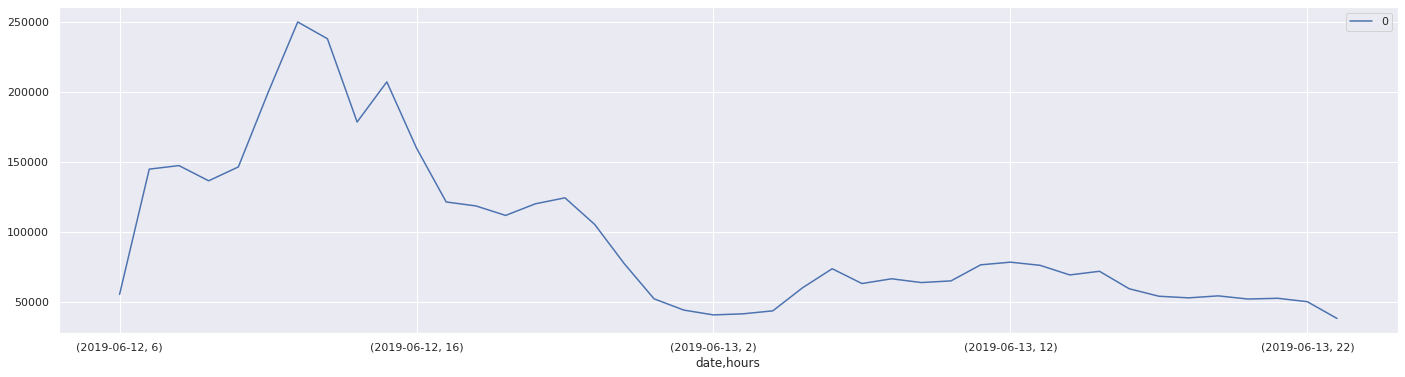

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(24,6)
#ax.set_xticks(range(6,48,1))
#ax.set_xticklabels((range(6,48,1)))
floor_data.reset_index().query('date == "2019-06-12" or date == "2019-06-13"').groupby(['date','hours']).sum().drop(columns=['minutes']).plot(ax=ax)

In [9]:
# Removing first and last days from the data
reduced_data_tmp = floor_data.reset_index() 
reduced_data_tmp = reduced_data_tmp[reduced_data_tmp.date != '2019-06-12']
reduced_data_tmp = reduced_data_tmp[reduced_data_tmp.date != '2019-08-06']
reduced_data_tmp.columns = ['hash','date','hours','minutes','count']
reduced_data_tmp = reduced_data_tmp[~((reduced_data_tmp.date == "2019-06-13") & (reduced_data_tmp.hours <= 6))]
reduced_data_tmp = reduced_data_tmp[~((reduced_data_tmp.date == "2019-08-05") & (reduced_data_tmp.hours >= 6))]

In [10]:
pre_reduce_h_data = floor_data.reset_index().query('hash == "e93fa2ab48a1d7f395028dbb379c406b"').groupby(['date','hours']).sum().drop(columns=['minutes'])

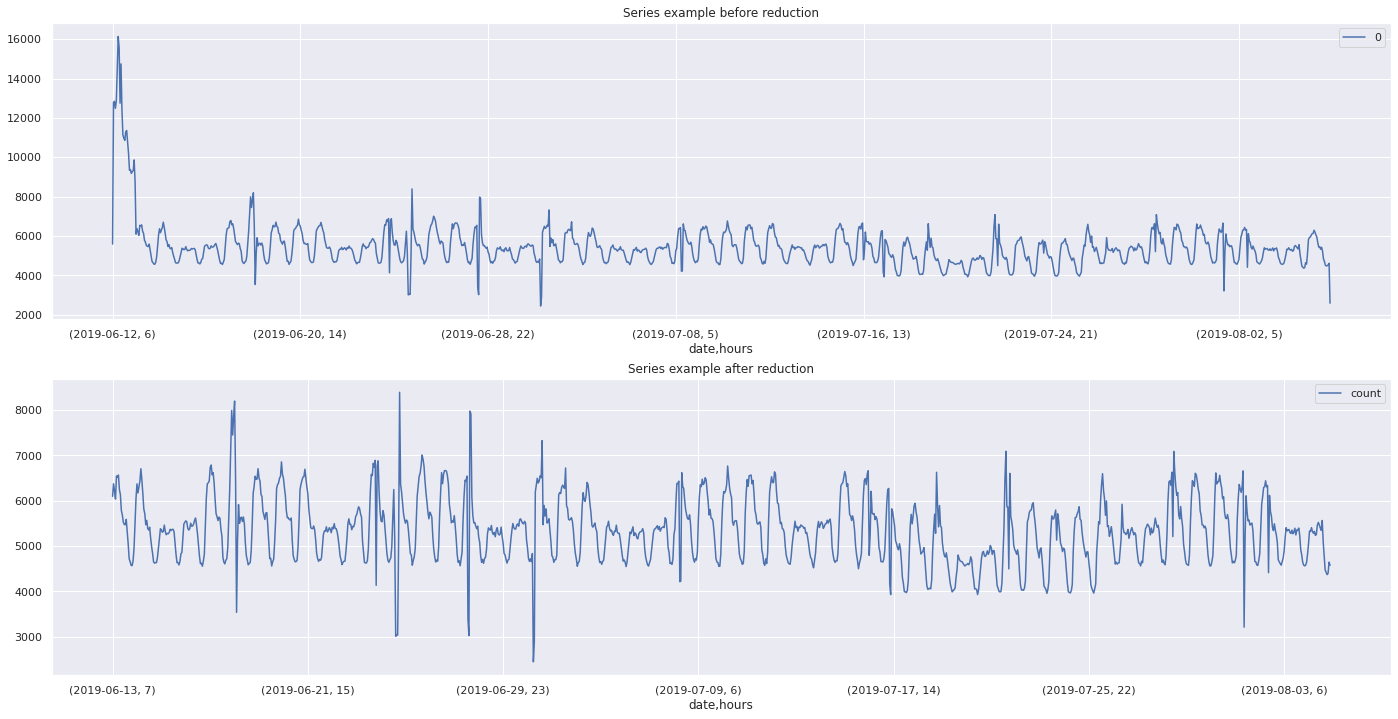

In [11]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(24, 12)
p1 = pre_reduce_h_data.plot(ax=ax[0], label="Pre-reduction data")
p2 = reduced_data_tmp.query('hash == "e93fa2ab48a1d7f395028dbb379c406b"').groupby(['date','hours']).sum().drop(columns=['minutes']).plot(ax=ax[1])
p1.set_title("Series example before reduction")
p2.set_title("Series example after reduction")
plt.show()

The graph above shows an example time series affected by the listed anomalies. We can see the initial spike and sudden downturn in the first example. These anomalies are eliminated after cutting the data.

## Removing non-reoccuring hashes #




A large portion of the dataset consists of hashes not appearing more than once. An additional significant portion of the data consists of hashes with less than a hundred occurrences.

To reduce the volume of data, the items with little to no usefulness for forecasting are eliminated. In this context, it is the items that don't reach the number of requests as defined earlier in the notebook.

The split between reoccurring and non-reoccurring is defined as one hundred requests. This number is arbitrary. Initially, the goal was to define this number based on insights gained from resulting time series clusters. However, the amount of data forces a decision here as if the split is too low, the amount of time needed to calculate the features will skyrocket to weeks. The feature calculation could be optimised, but even with the most optimistic expectation, the amount of time needed to calculate the features still seems unbearably high.

This is done now so that the deletion of the first and last days doesn't create new non-reoccurring hashes.

In [ ]:
reduced_data_tmp['count'].sum()

In [17]:
hash_sizes = reduced_data_tmp.drop(columns=['hours','minutes']).groupby(['hash']).sum() #floor_data.groupby(['hash']).sum()
non_reoccuring = hash_sizes[hash_sizes <= 1].dropna().index
reoccuring = hash_sizes[hash_sizes >= non_reoccuring_number].dropna().index
reoccuring_fd_index = reduced_data_tmp.hash.isin(reoccuring)

In [18]:
reoccuring_data = reduced_data_tmp[reoccuring_fd_index]
reoccuring_data = reoccuring_data.groupby(['hash','date','hours','minutes']).sum()
reoccuring_data.columns = ['count']
reoccuring_data = reoccuring_data.reset_index()
reoccuring_data['date_dt'] = pd.to_datetime(reoccuring_data['date'])
reoccuring_data['dayofweek'] = reoccuring_data.date_dt.dt.dayofweek

In [22]:
reoccuring_data['count'].sum()

56982512

## Downtime on 2019-07-01 to 2019-07-02 

In [11]:
# Data covering the start and end of downtime
anomaly_data = reoccuring_data[reoccuring_data.date == '2019-07-01'].drop(columns=['dayofweek']).groupby(['date','hours','minutes']).sum()
post_anomaly_data = reoccuring_data[reoccuring_data.date == '2019-07-02'].drop(columns=['dayofweek']).groupby(['date','hours','minutes']).sum()

In [12]:
anomaly_start_hour = anomaly_data.reset_index().hours.max()
anomaly_start = anomaly_data.reset_index().query(f'hours == {anomaly_start_hour}')
anomaly_start_minutes = anomaly_start.minutes.max()

In [13]:
anomaly_end_hour = post_anomaly_data.reset_index().hours.min()
anomaly_end = post_anomaly_data.reset_index().query(f'hours == {anomaly_end_hour}')
anomaly_end_minutes = anomaly_end.minutes.min()

In [14]:
print(f'Last requests recieved at Monday 01.07.2019 {anomaly_start_hour} hours and {anomaly_start_minutes} minutes.')
print(f'New requests coming in at Tuesday 02.07.2019 {anomaly_end_hour} hours and {anomaly_end_minutes} minutes.')

Last requests recieved at Monday 01.07.2019 6 hours and 15 minutes.
New requests coming in at Tuesday 02.07.2019 6 hours and 15 minutes.


## Closer look at the downtime ##

In [15]:
working_week_data = reoccuring_data.query('dayofweek != 5 & dayofweek != 6').drop(columns=['dayofweek','date_dt'])

In [16]:
# Previous Monday-Tuesday
previous_week = working_week_data.query(f'(date == "2019-06-24" & hours >= {anomaly_start_hour} & minutes >= {anomaly_start_minutes}) \
                                        | (date == "2019-06-25" & hours <= {anomaly_end_hour} & minutes <= {anomaly_end_minutes})')
#
previous_week = previous_week.groupby(['date','hours','minutes']).sum().reset_index()
previous_week['date'] =  pd.to_datetime(previous_week['date'])
previous_week['shifted'] = previous_week['date'] + timedelta(days=+7)
previous_week['shifted_combined'] = previous_week.shifted.dt.strftime('%Y-%m-%d') \
                            + " " + previous_week.hours.apply(str) \
                            + ":" + previous_week.minutes.apply(str)
previous_week.columns = ['date','hours','minutes','count','shifted','shifted_combined']
# Following Monday-Tuesday
following_week = working_week_data.query(f'(date == "2019-07-08" & hours >= {anomaly_start_hour} & minutes >= {anomaly_start_minutes}) \
                                         | (date == "2019-07-09" & hours <= {anomaly_end_hour} & minutes <= {anomaly_end_minutes})')
#
following_week = following_week.groupby(['date','hours','minutes']).sum().reset_index()
following_week['date'] =  pd.to_datetime(following_week['date'])
following_week['shifted'] = following_week['date'] + timedelta(days=-7)
following_week['shifted_combined'] = following_week.shifted.dt.strftime('%Y-%m-%d') \
                            + " " + following_week.hours.apply(str) \
                            + ":" + following_week.minutes.apply(str)
following_week.columns = ['date','hours','minutes','count','shifted','shifted_combined']

In [17]:
downtime_data = anomaly_data.reset_index().append(post_anomaly_data.reset_index())
downtime_data['combined'] = downtime_data['date'].apply(str) + " " + downtime_data['hours'].apply(str) + ":" + downtime_data['minutes'].apply(str)
downtime_data.columns = ['date','hours','minutes','count','combined']

In [18]:
downtime_interval = []
for day in ('2019-07-01','2019-07-02'):
    for hour in range(0,24):
        for minutes in range(0, 60, minute_floor):
            #anomaly_interval.append(day+" "+str(hour)+" "+str(minutes))
            combined_dt = day+" "+str(hour)+":"+str(minutes)
            if not combined_dt in downtime_data['combined'].values:
                downtime_data = downtime_data.append({'date':day, 'hours':hour, 'minutes':minutes, 'count':0, 'combined':combined_dt}, ignore_index=True)
                downtime_interval.append((day, hour, minutes))

In [19]:
downtime_data = downtime_data.sort_values(['date','hours','minutes'])
previous_week = previous_week.sort_values(['date','hours','minutes'])
following_week = following_week.sort_values(['date','hours','minutes'])

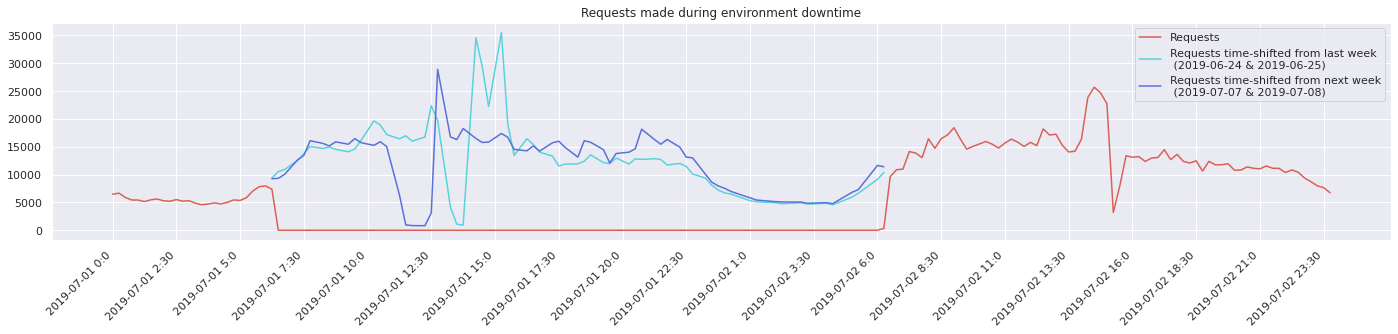

In [20]:
plt.close()
fig, ax = plt.subplots()
fig.set_size_inches(24, 4)
ax.set_title(f"Requests made during environment downtime")
ax.plot(downtime_data.combined, downtime_data['count'], label="Requests", color=sns.color_palette("hls", 8)[0])
ax.plot(previous_week.shifted_combined, previous_week['count'], \
        label="Requests time-shifted from last week\n (2019-06-24 & 2019-06-25)", color=sns.color_palette("hls", 8)[4])
ax.plot(following_week.shifted_combined, following_week['count'], \
        label="Requests time-shifted from next week\n (2019-07-07 & 2019-07-08)", color=sns.color_palette("hls", 8)[5])
ax.xaxis.set_ticks(range(0, len(downtime_data.combined), 10))
plt.xticks(rotation=45, ha="right")
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.plot()
ax.legend()

In the previous graph, we can see that the requests coming in the week before and after the downtime look seem to fit quite well into the gap.

This, however, is a total sum of all item requests. Solving this issue on an individual level will not be as easy.

On the single-item level, the problem is addressed more generally with mean values, as many time series might lack data from the following or previous week. Only items that have been requested before and after the downtime go through this transformation. If a time series ceased to be requested before the downtime, there is no point in introducing noise by adding mean values to this otherwise likely empty time period.

In [21]:
pre_downtime_hashes = reoccuring_data[reoccuring_data['date'] <= "2019-07-01"]['hash'].unique()
post_downtime_hashes = reoccuring_data[reoccuring_data['date'] >= "2019-07-02"]['hash'].unique()
pre_downtime_hashes.sort()
post_downtime_hashes.sort()
downtime_affected = list(filter(set(pre_downtime_hashes).__contains__, post_downtime_hashes))

In [22]:
print(f'Hashes appearing before and after downtime: {len(downtime_affected)}')

Hashes appearing before and after downtime: 2486


In [23]:
hash_means = reoccuring_data[reoccuring_data['hash'].isin(downtime_affected)].drop(columns=['dayofweek']).groupby(['hash','hours','minutes']).mean().reset_index()
hash_means.columns = ['hash','hours','minutes','mean']

In [24]:
hash_means = hash_means[~((hash_means['hours'] == anomaly_start_hour) & (hash_means['minutes'] == anomaly_start_minutes))]

In [25]:
# This condition might introduce 0's into dates when using non 5-minute intervals
conditions = [
(((hash_means['hours'] == 6) & (hash_means['minutes'] > anomaly_start_minutes)) | (hash_means['hours'] > anomaly_start_hour)),
(((hash_means['hours'] == 6) & (hash_means['minutes'] < anomaly_end_minutes)) | (hash_means['hours'] < anomaly_end_hour))
]


choices = ["2019-07-01","2019-07-02"]
hash_means['date'] = np.select(conditions, choices)
hash_means.columns = ['hash','hours','minutes','count','date']
hash_means = hash_means[['hash','date','hours','minutes','count']]

In [26]:
reoccuring_data = reoccuring_data.drop(columns=['dayofweek','date_dt'])

In [27]:
hash_means.query('date == "0"')

Empty DataFrame
Columns: [hash, date, hours, minutes, count]
Index: []

In [28]:
fixed_data = reoccuring_data.append(hash_means, ignore_index=True)

In [29]:
fixed_data.query('date == "0"')

Empty DataFrame
Columns: [hash, date, hours, minutes, count]
Index: []

In [30]:
reoccuring_data['combined'] = reoccuring_data['date'].apply(str) + " " + reoccuring_data['hours'].apply(str) + ":" + reoccuring_data['minutes'].apply(str)
fixed_data['combined'] = fixed_data['date'].apply(str) + " " + fixed_data['hours'].apply(str) + ":" + fixed_data['minutes'].apply(str)

In [31]:
reoccuring_data = reoccuring_data.sort_values(['date','hours','minutes'])
fixed_data = fixed_data.sort_values(['date','hours','minutes'])

In [32]:
def show_downtime_fix(fixed_data, original_data, hash_id, ax, colors):
    fixed_ts = fixed_data.query(f'hash == "{hash_id}" & ((date == "2019-07-01") | (date == "2019-07-02"))')
    downtime_ts = original_data.query(f'hash == "{hash_id}" & (date == "2019-07-01" | date == "2019-07-02")')
    #for day in ('2019-07-01','2019-07-02'):
    #    for hour in range(0,24):
    #        for minutes in range(0, 60, minute_floor):
    #            combined_dt = day+" "+str(hour)+":"+str(minutes)
    #            if not combined_dt in downtime_t1['combined'].values:
    #                downtime_ts = downtime_ts.append({'date':day, 'hours':hour, 'minutes':minutes, 'count':0, 'combined':combined_dt}, ignore_index=True)    
    pre_downtime = downtime_ts.query('date == "2019-07-01"')
    post_downtime = downtime_ts.query('date == "2019-07-02"')
    print(f'{hash_id} on 2019-07-01 originally had {len(pre_downtime)} requests')
    print(f'{hash_id} on 2019-07-02 originally had {len(post_downtime)} requests')
    #ax.plot(downtime_ts.combined, downtime_ts['count'], label="Original data", color=colors[1])
    ax.plot(fixed_ts.combined, fixed_ts['count'], label="Corrected data", color=colors[0])
    ax.plot(pre_downtime.combined, pre_downtime['count'], label="Original data", color=colors[1])
    ax.plot(post_downtime.combined, post_downtime['count'], color=colors[1])
    ax.legend()
    
    ax.xaxis.set_ticks(range(0, len(fixed_ts.combined), 10))
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.xaxis.set_tick_params(rotation=90)
    #plt.plot()

60940bbf1a3b82169641ba159686a6ca on 2019-07-01 originally had 26 requests
60940bbf1a3b82169641ba159686a6ca on 2019-07-02 originally had 71 requests
d03517f419b520bed290a38e43f578d5 on 2019-07-01 originally had 26 requests
d03517f419b520bed290a38e43f578d5 on 2019-07-02 originally had 71 requests
4e395735b02fc10b9ffc1ca9c28c984f on 2019-07-01 originally had 26 requests
4e395735b02fc10b9ffc1ca9c28c984f on 2019-07-02 originally had 71 requests
8d8b99524b2319835b6caec2dd369b12 on 2019-07-01 originally had 26 requests
8d8b99524b2319835b6caec2dd369b12 on 2019-07-02 originally had 71 requests
23e510e77a556241ec01dad0f70b4c92 on 2019-07-01 originally had 9 requests
23e510e77a556241ec01dad0f70b4c92 on 2019-07-02 originally had 23 requests


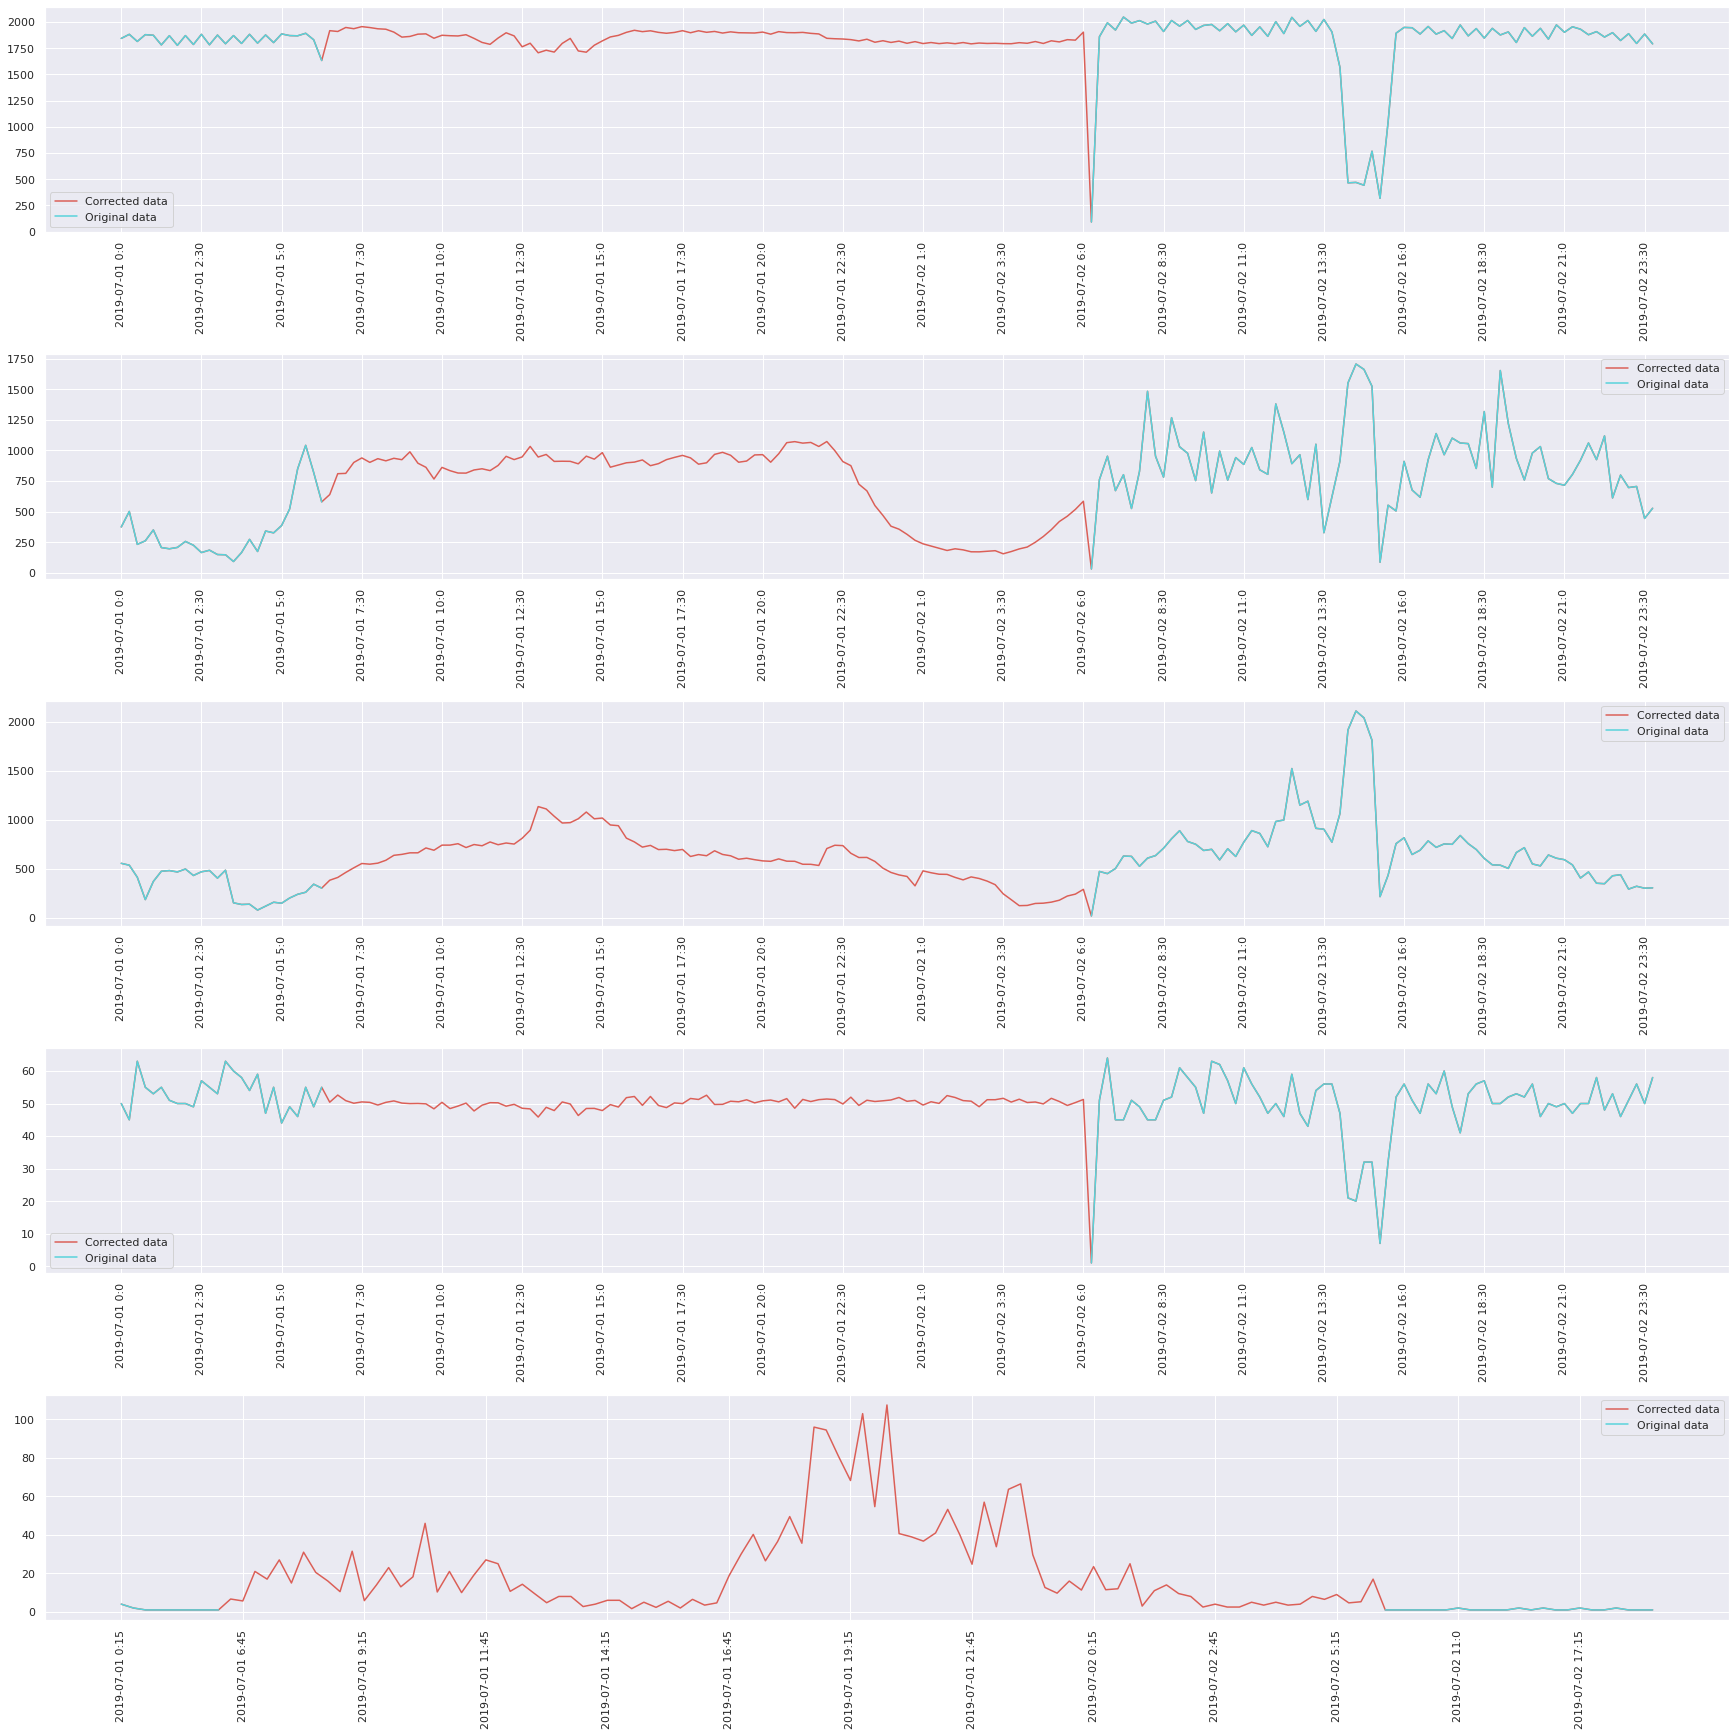

In [33]:
fig, ax = plt.subplots(5,1, constrained_layout=True)
fig.set_size_inches(24, 24)
#fig.tight_layout()
show_downtime_fix(fixed_data, reoccuring_data, "60940bbf1a3b82169641ba159686a6ca", ax[0], sns.color_palette("hls", 2))
show_downtime_fix(fixed_data, reoccuring_data, "d03517f419b520bed290a38e43f578d5", ax[1], sns.color_palette("hls", 2))
show_downtime_fix(fixed_data, reoccuring_data, "4e395735b02fc10b9ffc1ca9c28c984f", ax[2], sns.color_palette("hls", 2))
show_downtime_fix(fixed_data, reoccuring_data, "8d8b99524b2319835b6caec2dd369b12", ax[3], sns.color_palette("hls", 2))
show_downtime_fix(fixed_data, reoccuring_data, "23e510e77a556241ec01dad0f70b4c92", ax[4], sns.color_palette("hls", 2))

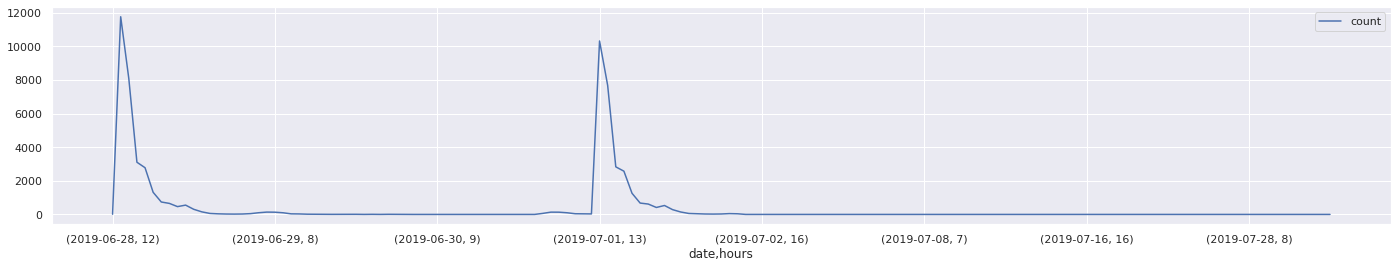

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 4)
fixed_data.query('hash == "9cf43a76bac1a739dcde9735f515bcfa"').sort_values(['date','hours']).drop(columns=['minutes']).groupby(['date','hours']).sum().plot(ax=ax)

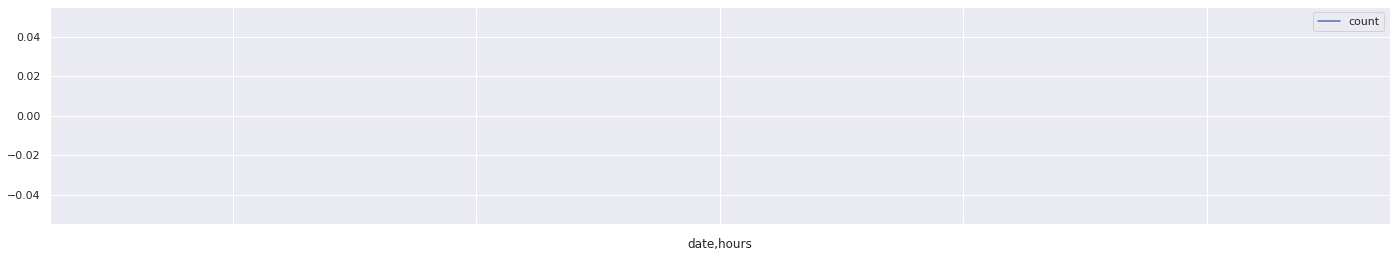

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 4)
fixed_data.query('hash == "a22a87bd6b37676a79ebad706aa1f015"').sort_values(['date','hours']).drop(columns=['minutes']).groupby(['date','hours']).sum().plot(ax=ax)

This method seems to do a decent job of fixing the gap. There are, however, some problems, some hashes seem to lack fluctuations, and the mean values seem relatively static, while others that did not have any in the first place (hashes that had a spike outside of the downtime) now have a mean-value spike despite the reality likely being that they maintained a mostly constant low number of requests.

It is necessary to take into account that the different quality of outcome for different kinds of hashes might not be a significant problem, we need to keep in mind that, in the end, we will be interested in forecasting certain types of hashes, not necessarily hashes that observe constant levels.

Text(0.5, 1.0, 'Total requested links through tracked time, tracked time (minutes)')

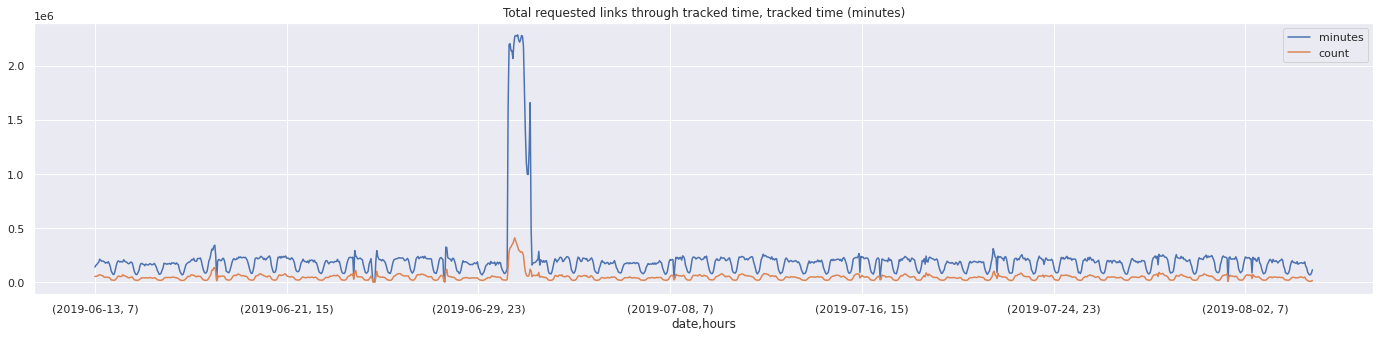

In [39]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 5)
fixed_data.groupby(['date','hours']).sum().plot(ax=ax)
ax.set_title("Total requested links through tracked time, tracked time (minutes)")

In the graph above, we can see a significant spike in the sum of requests where the downtime used to be. This is a side effect of the attempts to fix the time series. Individually, the items contain gaps, during which no requests were received. Since we artificially provided a full 24-hour interval, this will lead to items having more logged time, as can be observed by the even more dramatic increase in the sum of minutes which otherwise is much closer to the request count.

To potentially fix this problem, one would need to eliminate the 0 gaps in the all-time series. A very drastic approach that, if taken, should be limited to time series high in demand; otherwise, a similar effect as has been observed with the last example time series (23e510e77a556241ec01dad0f70b4c92) will appear. Items that likely saw no activity would suddenly massively gain in popularity.

We, however, need to keep in mind that this issue is most visible when working with sums of all-time series, and individually as observed above, might not even be a problem.

This will be addressed in later chapters.

Text(0.5, 1.0, 'Mean requests through tracked time')

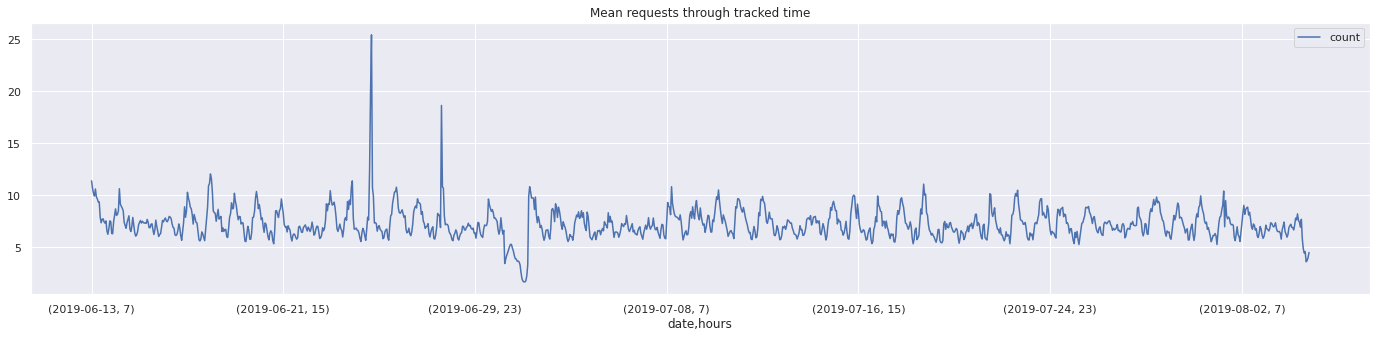

In [40]:
fig, ax = plt.subplots()
fig.set_size_inches(24, 5)
fixed_data.drop(columns=['minutes']).groupby(['date','hours']).mean().plot(ax=ax)
ax.set_title("Mean requests through tracked time")

Another interesting observation is that while the total sum sees a sudden spike, the mean of all items still sees a drop in requests. 

In [41]:
#fixed_data.to_csv(f"../../data/corrected_data_{minute_floor}_{non_reoccuring_number}.csv", index=False)